In [339]:
#Librairies
import pandas as pd
import numpy as np
import math
from datetime import timezone, datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from pyproj import Geod

from sklearn.preprocessing import KBinsDiscretizer
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from shapely.geometry import MultiLineString
from shapely.ops import polygonize
import geopandas as gpd
from shapely.geometry import Point
from geopandas.tools import sjoin
from adjustText import adjust_text 

import itertools
import collections
from collections import Counter

%matplotlib inline

In [340]:
df_dev = pd.read_csv('donnees_GNSS_Europa.csv', sep=',', header=0)

In [341]:
df_dev.head()

devadd  gatewayid   timestamp  snr  rssi        lat        lng    ehpe  \
0  1ff0fe9c          0  1610930653   13   -70 -22.343824  40.340537  79.282   
1  1ff0fe9c          0  1610930772   13   -65 -22.343997  40.340147  27.729   
2  1ff0fe9c          0  1610930891   12   -67 -22.344038  40.340096   4.570   
3  1ff0fe9c          0  1610931010    8   -67 -22.344044  40.340106   3.690   
4  1ff0fe9c          0  1610931129    9   -67 -22.344044  40.340106   3.669   

    hdop  ttf  nbSat  noFixCount  zeroSatTimeout  
0  10300    0     16           0               0  
1   1230    0     16           0               0  
2    990    0     20           0               0  
3    960    0     19           0               0  
4    960    0     19           0               0

In [342]:
df_gtw = pd.read_csv('Suivi_info_gateway_tortue.csv', sep=',', header=0)

In [343]:
df_gtw.head()

Pseudo    model               eui sub-network role in network  short ID  \
0      Main  RAK7249  ac1f09fffe00a96d      Europa         Main GW         0   
1      dune  RAK7249  ac1f09fffe00a84f      Europa    Secondary GW         5   
2     lagon  RAK7249  ac1f09fffe00a8d6      Europa    Secondary GW         3   
3  mangrove  RAK7249  ac1f09fffe00a8d2      Europa    Secondary GW         4   

  Program loaded  ping freq               System time           Id / pwd  \
0       Main-gtw         no  UTC (updated 01/06/2021)  root / ifremer974   
1  Secondary-gtw  868.3 MHz  UTC (updated 01/06/2021)        root / root   
2  Secondary-gtw  867.7 MHz  UTC (updated 01/06/2021)        root / root   
3  Secondary-gtw  867.3 MHz  UTC (updated 01/06/2021)        root / root   

  Tunnel VPN Openvpn name Target application network  Longitude   Latitude  
0  Disabled             -                 Chirpstack  40.340192 -22.343807  
1   Disabled            -                 Chirpstack  40.372063 -22.342677  
2   Disabled            -                 Chirpstack  40.375278 -22.358056  
3   Disabled            -                 Chirpstack  40.391667 -22.364167

In [344]:
df = pd.DataFrame()
df = df_dev.drop(['devadd','hdop','ttf','nbSat','noFixCount','zeroSatTimeout'],axis=1)
df = pd.merge(df,df_gtw[['short ID', 'Pseudo','Longitude', 'Latitude']],left_on='gatewayid',right_on='short ID', how='left').drop('short ID', axis=1)
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.rename(columns={"lat": "objlat", "lng": "objlng", "Longitude":"gatewaylng", "Latitude":"gatewaylat", "Pseudo":"gatewayname"})
#df['rssi'] = df['rssi']-256
#df['rssi'] = df.apply(lambda row: row['rssi']-256 if row['rssi']> 0 else row['rssi'], axis=1)
#df.set_index(['timestamp','gatewayid'], inplace=True)
#df['rssi'] = df['rssi'].mask(df['rssi']>0)
#df.dropna()
df.drop(df.index[df['rssi']>0], inplace = True)
df.head()

gatewayid           timestamp  snr  rssi     objlat     objlng    ehpe  \
0          0 2021-01-18 00:44:13   13   -70 -22.343824  40.340537  79.282   
1          0 2021-01-18 00:46:12   13   -65 -22.343997  40.340147  27.729   
2          0 2021-01-18 00:48:11   12   -67 -22.344038  40.340096   4.570   
3          0 2021-01-18 00:50:10    8   -67 -22.344044  40.340106   3.690   
4          0 2021-01-18 00:52:09    9   -67 -22.344044  40.340106   3.669   

  gatewayname  gatewaylng  gatewaylat  
0        Main   40.340192  -22.343807  
1        Main   40.340192  -22.343807  
2        Main   40.340192  -22.343807  
3        Main   40.340192  -22.343807  
4        Main   40.340192  -22.343807

In [345]:
wgs84_geod = Geod(ellps='WGS84')

def Distance(lat1,lon1,lat2,lon2):
  az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2)
  return dist

#Distance en mètre
df['distancegps'] = Distance(df['gatewaylat'].tolist(),df['gatewaylng'].tolist(),df['objlat'].tolist(),df['objlng'].tolist())
df.head()

gatewayid           timestamp  snr  rssi     objlat     objlng    ehpe  \
0          0 2021-01-18 00:44:13   13   -70 -22.343824  40.340537  79.282   
1          0 2021-01-18 00:46:12   13   -65 -22.343997  40.340147  27.729   
2          0 2021-01-18 00:48:11   12   -67 -22.344038  40.340096   4.570   
3          0 2021-01-18 00:50:10    8   -67 -22.344044  40.340106   3.690   
4          0 2021-01-18 00:52:09    9   -67 -22.344044  40.340106   3.669   

  gatewayname  gatewaylng  gatewaylat  distancegps  
0        Main   40.340192  -22.343807    35.606578  
1        Main   40.340192  -22.343807    21.547111  
2        Main   40.340192  -22.343807    27.420959  
3        Main   40.340192  -22.343807    27.726208  
4        Main   40.340192  -22.343807    27.684867

In [346]:
grouped_gtw=df.groupby("gatewayname")

In [347]:
#Discretize
#df['group_rssi'] = df.groupby('gatewayname')[['rssi']].transform(lambda x: pd.cut(x, bins = 50).astype(str))
df['group_rssi'] = df['rssi'].transform(lambda x: pd.cut(x, bins = 20).astype(str))
df.head()

gatewayid           timestamp  snr  rssi     objlat     objlng    ehpe  \
0          0 2021-01-18 00:44:13   13   -70 -22.343824  40.340537  79.282   
1          0 2021-01-18 00:46:12   13   -65 -22.343997  40.340147  27.729   
2          0 2021-01-18 00:48:11   12   -67 -22.344038  40.340096   4.570   
3          0 2021-01-18 00:50:10    8   -67 -22.344044  40.340106   3.690   
4          0 2021-01-18 00:52:09    9   -67 -22.344044  40.340106   3.669   

  gatewayname  gatewaylng  gatewaylat  distancegps       group_rssi  
0        Main   40.340192  -22.343807    35.606578  (-72.7, -68.75]  
1        Main   40.340192  -22.343807    21.547111  (-68.75, -64.8]  
2        Main   40.340192  -22.343807    27.420959  (-68.75, -64.8]  
3        Main   40.340192  -22.343807    27.726208  (-68.75, -64.8]  
4        Main   40.340192  -22.343807    27.684867  (-68.75, -64.8]

In [348]:
step = 9
M = np.linspace(df['objlng'].min(), df['objlng'].max(), step)
N = np.linspace(df['objlat'].min(), df['objlat'].max(), step)

hlines = [((x1, yi), (x2, yi)) for x1, x2 in zip(M[:-1], M[1:]) for yi in N]
vlines = [((xi, y1), (xi, y2)) for y1, y2 in zip(N[:-1], N[1:]) for xi in M]

polys = list(polygonize(MultiLineString(hlines + vlines)))
idx = [i for i in range(len(polys))]
grid = gpd.GeoDataFrame({"id":idx,"geometry":polys})

In [349]:
df_geo = df.filter(['rssi','objlng','objlat','gatewayname', 'group_rssi'],axis=1)
gdf = gpd.GeoDataFrame(
    df_geo, geometry=gpd.points_from_xy(df_geo['objlng'], df_geo['objlat']))

grouped = gdf.groupby('gatewayname')
grouped.head()

rssi     objlng     objlat gatewayname           group_rssi  \
0      -70  40.340537 -22.343824        Main      (-72.7, -68.75]   
1      -65  40.340147 -22.343997        Main      (-68.75, -64.8]   
2      -67  40.340096 -22.344038        Main      (-68.75, -64.8]   
3      -67  40.340106 -22.344044        Main      (-68.75, -64.8]   
4      -67  40.340106 -22.344044        Main      (-68.75, -64.8]   
100   -127  40.374426 -22.347767    mangrove  (-128.079, -124.05]   
127   -127  40.378053 -22.357132    mangrove  (-128.079, -124.05]   
134   -126  40.377139 -22.357668        dune  (-128.079, -124.05]   
136   -128  40.377142 -22.357674        dune  (-128.079, -124.05]   
138   -127  40.377136 -22.357667        dune  (-128.079, -124.05]   
139   -127  40.377153 -22.357692        dune  (-128.079, -124.05]   
142   -127  40.377151 -22.357697        dune  (-128.079, -124.05]   
214   -127  40.381336 -22.355798    mangrove  (-128.079, -124.05]   
240   -128  40.374437 -22.347774       lagon  (-128.079, -124.05]   
256   -127  40.373146 -22.344162    mangrove  (-128.079, -124.05]   
785   -128  40.375540 -22.347539       lagon  (-128.079, -124.05]   
825   -127  40.386753 -22.357420    mangrove  (-128.079, -124.05]   
843   -128  40.390387 -22.363238       lagon  (-128.079, -124.05]   
860   -126  40.390407 -22.363238       lagon  (-128.079, -124.05]   
1064  -127  40.374389 -22.347813       lagon  (-128.079, -124.05]   

                        geometry  
0     POINT (40.34054 -22.34382)  
1     POINT (40.34015 -22.34400)  
2     POINT (40.34010 -22.34404)  
3     POINT (40.34011 -22.34404)  
4     POINT (40.34011 -22.34404)  
100   POINT (40.37443 -22.34777)  
127   POINT (40.37805 -22.35713)  
134   POINT (40.37714 -22.35767)  
136   POINT (40.37714 -22.35767)  
138   POINT (40.37714 -22.35767)  
139   POINT (40.37715 -22.35769)  
142   POINT (40.37715 -22.35770)  
214   POINT (40.38134 -22.35580)  
240   POINT (40.37444 -22.34777)  
256   POINT (40.37315 -22.34416)  
785   POINT (40.37554 -22.34754)  
825   POINT (40.38675 -22.35742)  
843   POINT (40.39039 -22.36324)  
860   POINT (40.39041 -22.36324)  
1064  POINT (40.37439 -22.34781)

In [350]:
pointInPolys = sjoin(gdf, grid, how='left')
#Number of points in cell (global)
#print(pointInPolys.groupby(['id']).size().reset_index(name='count'))

In [351]:
pointInPolys.head()

rssi     objlng     objlat gatewayname       group_rssi  \
0   -70  40.340537 -22.343824        Main  (-72.7, -68.75]   
1   -65  40.340147 -22.343997        Main  (-68.75, -64.8]   
2   -67  40.340096 -22.344038        Main  (-68.75, -64.8]   
3   -67  40.340106 -22.344044        Main  (-68.75, -64.8]   
4   -67  40.340106 -22.344044        Main  (-68.75, -64.8]   

                     geometry  index_right  id  
0  POINT (40.34054 -22.34382)           14  14  
1  POINT (40.34015 -22.34400)            6   6  
2  POINT (40.34010 -22.34404)            6   6  
3  POINT (40.34011 -22.34404)            6   6  
4  POINT (40.34011 -22.34404)            6   6

In [352]:
df_proba_msg = (
    pointInPolys.groupby(['gatewayname','group_rssi', 'id']).count() / pointInPolys.groupby(['gatewayname','group_rssi']).count()
)['rssi']\
.pipe(pd.DataFrame)\
.rename(columns = {'rssi': 'proba'})\
.reset_index()

df_proba_msg.head()

gatewayname        group_rssi  id     proba
0        Main  (-100.35, -96.4]   6  0.791411
1        Main  (-100.35, -96.4]   7  0.006135
2        Main  (-100.35, -96.4]  14  0.171779
3        Main  (-100.35, -96.4]  15  0.003067
4        Main  (-100.35, -96.4]  45  0.027607

In [353]:
#df_proba_msg[['id','group_rssi']].apply(pd.Series.value_counts)
occ = pd.DataFrame(df_proba_msg.groupby('group_rssi')['id'].value_counts().loc[lambda x : x>1])
occ = occ.rename(columns = {'id': 'count'}).reset_index()
occ.head()

group_rssi  id  count
0   (-100.35, -96.4]  45      3
1   (-100.35, -96.4]  14      2
2   (-100.35, -96.4]  46      2
3   (-100.35, -96.4]  59      2
4  (-104.3, -100.35]  45      4

In [354]:
arr_group_rssi = occ['group_rssi'].tolist()
arr_id_cell = occ['id'].tolist()

In [355]:
df_proba_msg.head()

gatewayname        group_rssi  id     proba
0        Main  (-100.35, -96.4]   6  0.791411
1        Main  (-100.35, -96.4]   7  0.006135
2        Main  (-100.35, -96.4]  14  0.171779
3        Main  (-100.35, -96.4]  15  0.003067
4        Main  (-100.35, -96.4]  45  0.027607

In [356]:
t = pd.merge(grid, df_proba_msg, on='id',  how='right')
t['coords'] = t['geometry'].apply(lambda x: x.representative_point().coords[:])
t['coords'] = [coords[0] for coords in t['coords']]
grouped = t.groupby(['group_rssi', 'gatewayname'], as_index=True)

In [357]:
t['tuples_plot'] = list(zip(t['group_rssi'], t['gatewayname']))

In [358]:
t.head()

id                                           geometry gatewayname  \
0   4  POLYGON ((40.34020 -22.36518, 40.33181 -22.365...        dune   
1   4  POLYGON ((40.34020 -22.36518, 40.33181 -22.365...       lagon   
2   4  POLYGON ((40.34020 -22.36518, 40.33181 -22.365...    mangrove   
3   5  POLYGON ((40.34020 -22.35731, 40.33181 -22.357...        Main   
4   5  POLYGON ((40.34020 -22.35731, 40.33181 -22.357...        Main   

            group_rssi     proba                                coords  \
0  (-128.079, -124.05]  0.006536  (40.3360025125, -22.361243112500002)   
1    (-124.05, -120.1]  0.017544  (40.3360025125, -22.361243112500002)   
2  (-128.079, -124.05]  0.009901  (40.3360025125, -22.361243112500002)   
3    (-116.15, -112.2]  0.022222  (40.3360025125, -22.353376737500003)   
4    (-124.05, -120.1]  0.027027  (40.3360025125, -22.353376737500003)   

                       tuples_plot  
0      ((-128.079, -124.05], dune)  
1       ((-124.05, -120.1], lagon)  
2  ((-128.079, -124.05], mangrove)  
3        ((-116.15, -112.2], Main)  
4        ((-124.05, -120.1], Main)

In [359]:
len(grouped.groups.keys())

71

In [360]:
grouped.get_group(('(-104.3, -100.35]', 'mangrove')) #key

id                                           geometry gatewayname  \
222  45  POLYGON ((40.38213 -22.35731, 40.37374 -22.357...    mangrove   
286  52  POLYGON ((40.39051 -22.36518, 40.38213 -22.365...    mangrove   
359  60  POLYGON ((40.39890 -22.36518, 40.39051 -22.365...    mangrove   

            group_rssi     proba                                     coords  \
222  (-104.3, -100.35]  0.142857  (40.377934637500005, -22.353376737500003)   
286  (-104.3, -100.35]  0.571429       (40.3863210625, -22.361243112500002)   
359  (-104.3, -100.35]  0.285714       (40.3947074875, -22.361243112500002)   

                       tuples_plot  
222  ((-104.3, -100.35], mangrove)  
286  ((-104.3, -100.35], mangrove)  
359  ((-104.3, -100.35], mangrove)

In [361]:
t.loc[t['tuples_plot']==('(-104.3, -100.35]', 'mangrove')]

id                                           geometry gatewayname  \
222  45  POLYGON ((40.38213 -22.35731, 40.37374 -22.357...    mangrove   
286  52  POLYGON ((40.39051 -22.36518, 40.38213 -22.365...    mangrove   
359  60  POLYGON ((40.39890 -22.36518, 40.39051 -22.365...    mangrove   

            group_rssi     proba                                     coords  \
222  (-104.3, -100.35]  0.142857  (40.377934637500005, -22.353376737500003)   
286  (-104.3, -100.35]  0.571429       (40.3863210625, -22.361243112500002)   
359  (-104.3, -100.35]  0.285714       (40.3947074875, -22.361243112500002)   

                       tuples_plot  
222  ((-104.3, -100.35], mangrove)  
286  ((-104.3, -100.35], mangrove)  
359  ((-104.3, -100.35], mangrove)

In [362]:
list_id = df_proba_msg['id'].unique()
list_id = sorted(list_id)

In [363]:
def check_list(l):
    if not l:
        return ['None']
    else:
        return l

In [364]:
tuples = list() #collections.defaultdict(list)
df_tuples = pd.DataFrame()
for idx in list_id :
    main = df_proba_msg[(df_proba_msg['gatewayname']=='Main') & (df_proba_msg['id']==idx)]['group_rssi'].tolist()
    lagon = df_proba_msg[(df_proba_msg['gatewayname']=='lagon') & (df_proba_msg['id']==idx)]['group_rssi'].tolist()
    dune = df_proba_msg[(df_proba_msg['gatewayname']=='dune') & (df_proba_msg['id']==idx)]['group_rssi'].tolist()
    mang = df_proba_msg[(df_proba_msg['gatewayname']=='mangrove') & (df_proba_msg['id']==idx)]['group_rssi'].tolist()
    
    for x,y,z,e in [(x,y,z,e) for x in check_list(main) for y in check_list(dune) for z in check_list(lagon) for e in check_list(mang)]:
        value = (x, y,z,e)
        tuples.append({ 'idcell':idx, 'tuplesrssi':value })
        #new_row = {'id_cell':idx, 'tuples_rssi_gtw':value}
        #df_tuples = df_tuples.append(new_row, ignore_index=True)

In [365]:
df_tuples = pd.DataFrame(tuples)
df_tuples.head()

idcell                                         tuplesrssi
0       4  (None, (-128.079, -124.05], (-124.05, -120.1],...
1       5              ((-116.15, -112.2], None, None, None)
2       5              ((-124.05, -120.1], None, None, None)
3       6  ((-100.35, -96.4], (-128.079, -124.05], None, ...
4       6  ((-104.3, -100.35], (-128.079, -124.05], None,...

In [366]:
proba_tuples = (df_tuples.reset_index().groupby('tuplesrssi')['idcell'].value_counts()/ df_tuples.reset_index().groupby('tuplesrssi')['idcell'].count())
proba_tuples = pd.DataFrame(proba_tuples)
proba_tuples = proba_tuples.rename(columns = {'idcell': 'proba'}).reset_index()

In [369]:
occ_proba_tuples = pd.DataFrame(proba_tuples[proba_tuples['proba'] > 0.2].groupby('idcell')['proba'].count())
occ_proba_tuples = occ_proba_tuples.rename(columns = {'proba': 'count'}).reset_index()
occ_proba_tuples.head()

idcell  count
0       5      2
1       6     19
2       7      8
3       8      1
4       9      1

In [ ]:
#from operator import itemgetter
#countries = Counter(map(itemgetter('binrssi'), tuples))
#countries

In [373]:
t = pd.merge(grid, occ_proba_tuples, how='right', left_on='id', right_on='idcell')
t['coords'] = t['geometry'].apply(lambda x: x.representative_point().coords[:])
t['coords'] = [coords[0] for coords in t['coords']]

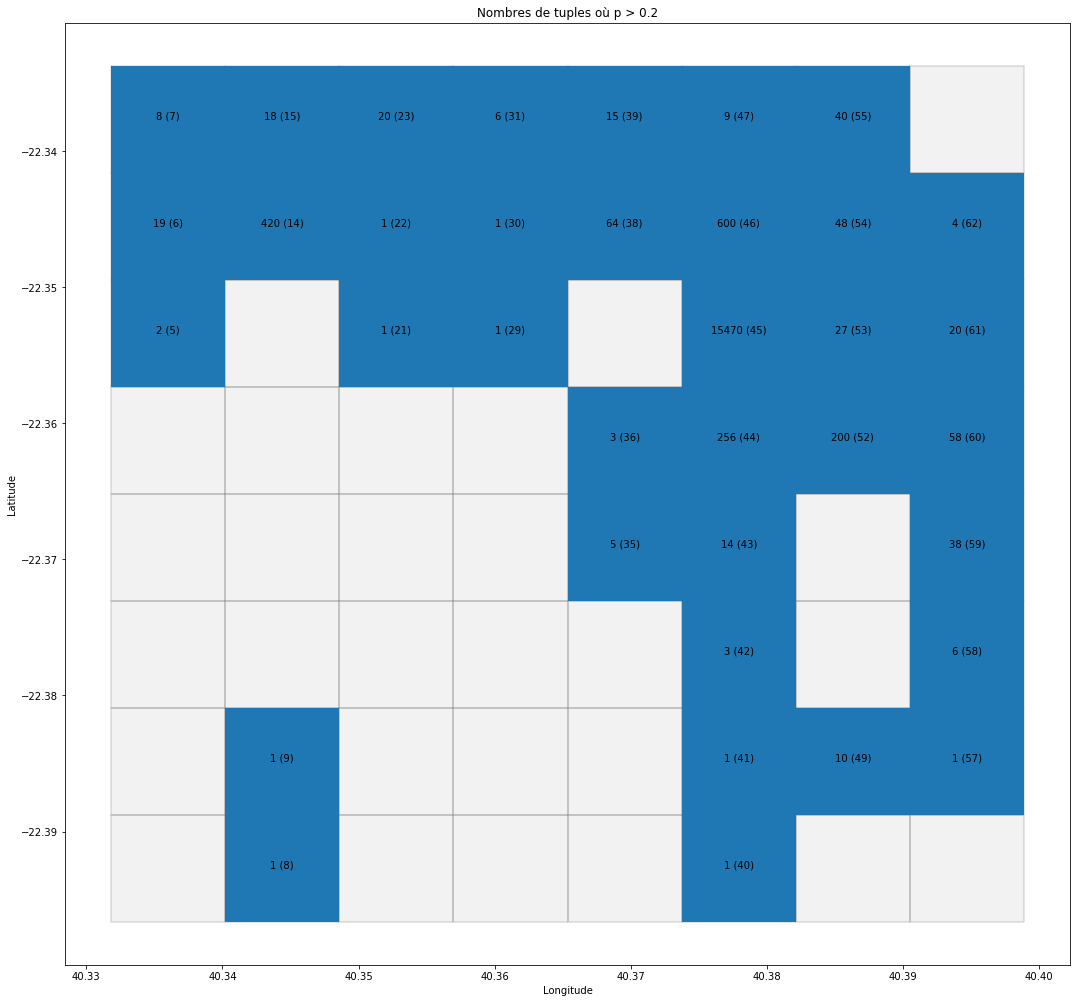

In [376]:
fig, ax = plt.subplots(figsize=(18,21))

grid.plot(ax=ax,facecolor='gray',alpha=.1,edgecolor='black',lw=2)
t.plot(ax=ax)
ax.set(xlabel="Longitude", ylabel="Latitude")
ax.set_title('Nombres de tuples où p > 0.2')
    
for idx, row in t.iterrows():
    ax.annotate(s=str(row['count'])+" ("+str(row['id'])+")", xy=row['coords'], horizontalalignment='center')
        
#plt.savefig('index.png', format='png')    